# Robustesse des réseaux de neurones face aux attaques adverses

## Lab: Alzheimer MRI Model  (Mohamed Ibn Khedher)

#### This notebook is inspired from [this link](https://www.kaggle.com/amyjang/alzheimer-mri-model-tensorflow-2-3-data-loading/notebook)

## Extraction des données :

In [1]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()


# importing required modules
from zipfile import ZipFile
  
# specifying the zip file name
file_name = "./Alzheimer_sDataset.zip"
  
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
    # extracting all the files
    zip.extractall()
    print('Done!')

C:\Users\liber\OneDrive\Documents\ESME\INGE 1\Semestre 2\MINEURES\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


File Name                                             Modified             Size
Alzheimer_s Dataset/                           2021-06-23 13:01:40            0
Alzheimer_s Dataset/test/                      2021-06-23 13:01:40            0
Alzheimer_s Dataset/test/MildDemented/         2021-06-23 13:01:38            0
Alzheimer_s Dataset/test/MildDemented/26 (19).jpg 2020-12-01 01:41:56         5203
Alzheimer_s Dataset/test/MildDemented/26 (20).jpg 2020-12-01 01:41:56         5347
Alzheimer_s Dataset/test/MildDemented/26 (21).jpg 2020-12-01 01:41:56         5346
Alzheimer_s Dataset/test/MildDemented/26 (22).jpg 2020-12-01 01:41:56         5100
Alzheimer_s Dataset/test/MildDemented/26 (23).jpg 2020-12-01 01:41:56         4864
Alzheimer_s Dataset/test/MildDemented/26 (24).jpg 2020-12-01 01:41:56         5422
Alzheimer_s Dataset/test/MildDemented/26 (25).jpg 2020-12-01 01:41:56         5211
Alzheimer_s Dataset/test/MildDemented/26 (26).jpg 2020-12-01 01:41:56         5288
Alzheimer_s Data

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
#from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import PIL
import keras

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
AUTOTUNE = tf.data.experimental.AUTOTUNE 
print(tf.__version__)

Number of replicas: 1
2.10.0


In [4]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [176, 208]

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Alzheimer_s Dataset/train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Alzheimer_s Dataset/train",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


In [6]:
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
train_ds.class_names = class_names
val_ds.class_names = class_names

NUM_CLASSES = len(class_names)

In [7]:
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    image = tf.cast(image/255. ,tf.float32)
    return image, label

train_ds = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

In [8]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Répartition des données parmi les classes :

In [9]:
NUM_IMAGES = []

for label in class_names:
    dir_name = "Alzheimer_s Dataset/train/" + label[:-2] + 'ed'
    NUM_IMAGES.append(len([name for name in os.listdir(dir_name)]))
    
NUM_IMAGES

[717, 52, 2560, 1792]

## Chargement du modèle de CNN :

In [10]:
model = keras.models.load_model("./alzheimer_model.h5")
model_50 = keras.models.load_model("./final_alzheimer_model.h5")

Instructions for updating:
Colocations handled automatically by placer.


### Architecture du modèle :

In [11]:
print(model.summary())

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 176, 208, 16)      448       
                                                                 
 conv2d_17 (Conv2D)          (None, 176, 208, 16)      2320      
                                                                 
 conv2d_18 (Conv2D)          (None, 176, 208, 16)      2320      
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 88, 104, 16)      0         
 g2D)                                                            
                                                                 
 sequential_48 (Sequential)  multiple                  2160      
                                                                 
 sequential_49 (Sequential)  multiple                  7392      
                                                     

In [12]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Alzheimer_s Dataset/test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1279 files belonging to 4 classes.


## Evaluation du modèle :

In [13]:
METRICS = [tf.keras.metrics.AUC(name='auc'),tf.keras.metrics.CategoricalAccuracy(name='Acc')]
model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )
_ = model_50.evaluate(test_ds)


import tensorflow_datasets as tfds

for image, label in tfds.as_numpy(val_ds):
  labels = label
  images = image
    
 
a = model.evaluate(images,labels)
print("Model loss: ",a[0]," | Model AUC: ", a[1], " | Model categorical accuracy: ", a[2])

C:\Users\liber\OneDrive\Documents\ESME\INGE 1\Semestre 2\MINEURES\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
C:\Users\liber\OneDrive\Documents\ESME\INGE 1\Semestre 2\MINEURES\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Model loss:  0.9340261816978455  | Model AUC:  0.8417969  | Model categorical accuracy:  0.6875


## Exemple du bruit Gaussien :

(176, 208, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


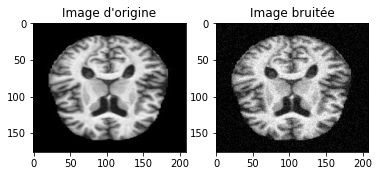

In [14]:
img_test = images[0]
print(img_test.shape)
plt.subplot(1,2,1)
plt.title("Image d'origine")
plt.imshow(img_test)

eps = 0.02

var = 10
sigma = var ** 0.5
gaussian = np.random.normal(0, sigma, (208, 176)) 
img_gauss=img_test + np.array([gaussian * eps,gaussian * eps,gaussian * eps]).transpose()
plt.subplot(1,2,2)
plt.title('Image bruitée')
plt.imshow(img_gauss, cmap='gray')

## IBM Adversarial Robustness Toolbox 
### Simulation d'attaques :

In [15]:
from art.attacks.evasion import FastGradientMethod

from art.estimators.classification import KerasClassifier
import os
import numpy as np
import pandas as pd
import tensorflow as tf
#from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import PIL
import keras
#On cree un classifier art base sur notre model


import tensorflow as tf
    
tf.compat.v1.disable_eager_execution()

model = keras.models.load_model("./alzheimer_model.h5")
classifier = KerasClassifier(model=model,clip_values=(0,1),use_logits=False)

liste_eps = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07,0.08,0.09,0.1]


C:\Users\liber\OneDrive\Documents\ESME\INGE 1\Semestre 2\MINEURES\lib\site-packages\art\estimators\certification\__init__.py:14: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")


### FGSM :

In [16]:
liste_FGSM = []
for i in liste_eps:
    liste_FGSM.append(FastGradientMethod(estimator=classifier, eps=i))

liste_img_FGSM = []
for attack in liste_FGSM:
    liste_img_FGSM.append(attack.generate(images))

liste_eval = []
for img in liste_img_FGSM:
    liste_eval.append(model.evaluate(img,labels))

liste_eval_50 = []
for img in liste_img_FGSM:
    liste_eval_50.append(model_50.evaluate(img,labels))

#-------------------EVALUATE ON GENERATED IMAGES----------------------
    
liste_loss=[]
for _ in liste_eval:
    liste_loss.append(_[0])


liste_auc=[]
for _ in liste_eval:
    liste_auc.append(_[1])


liste_acc=[]
for _ in liste_eval:
    liste_acc.append(_[2])

#---------------------FOR MODEL TRAINED ON 50 EPOCHS-------------------

liste_loss_50=[]
for _ in liste_eval_50:
    liste_loss_50.append(_[0])

liste_auc_50=[]
for _ in liste_eval_50:
    liste_auc_50.append(_[1])


liste_acc_50=[]
for _ in liste_eval_50:
    liste_acc_50.append(_[2])


C:\Users\liber\OneDrive\Documents\ESME\INGE 1\Semestre 2\MINEURES\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
C:\Users\liber\OneDrive\Documents\ESME\INGE 1\Semestre 2\MINEURES\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Effet du FGSM sur nos images :


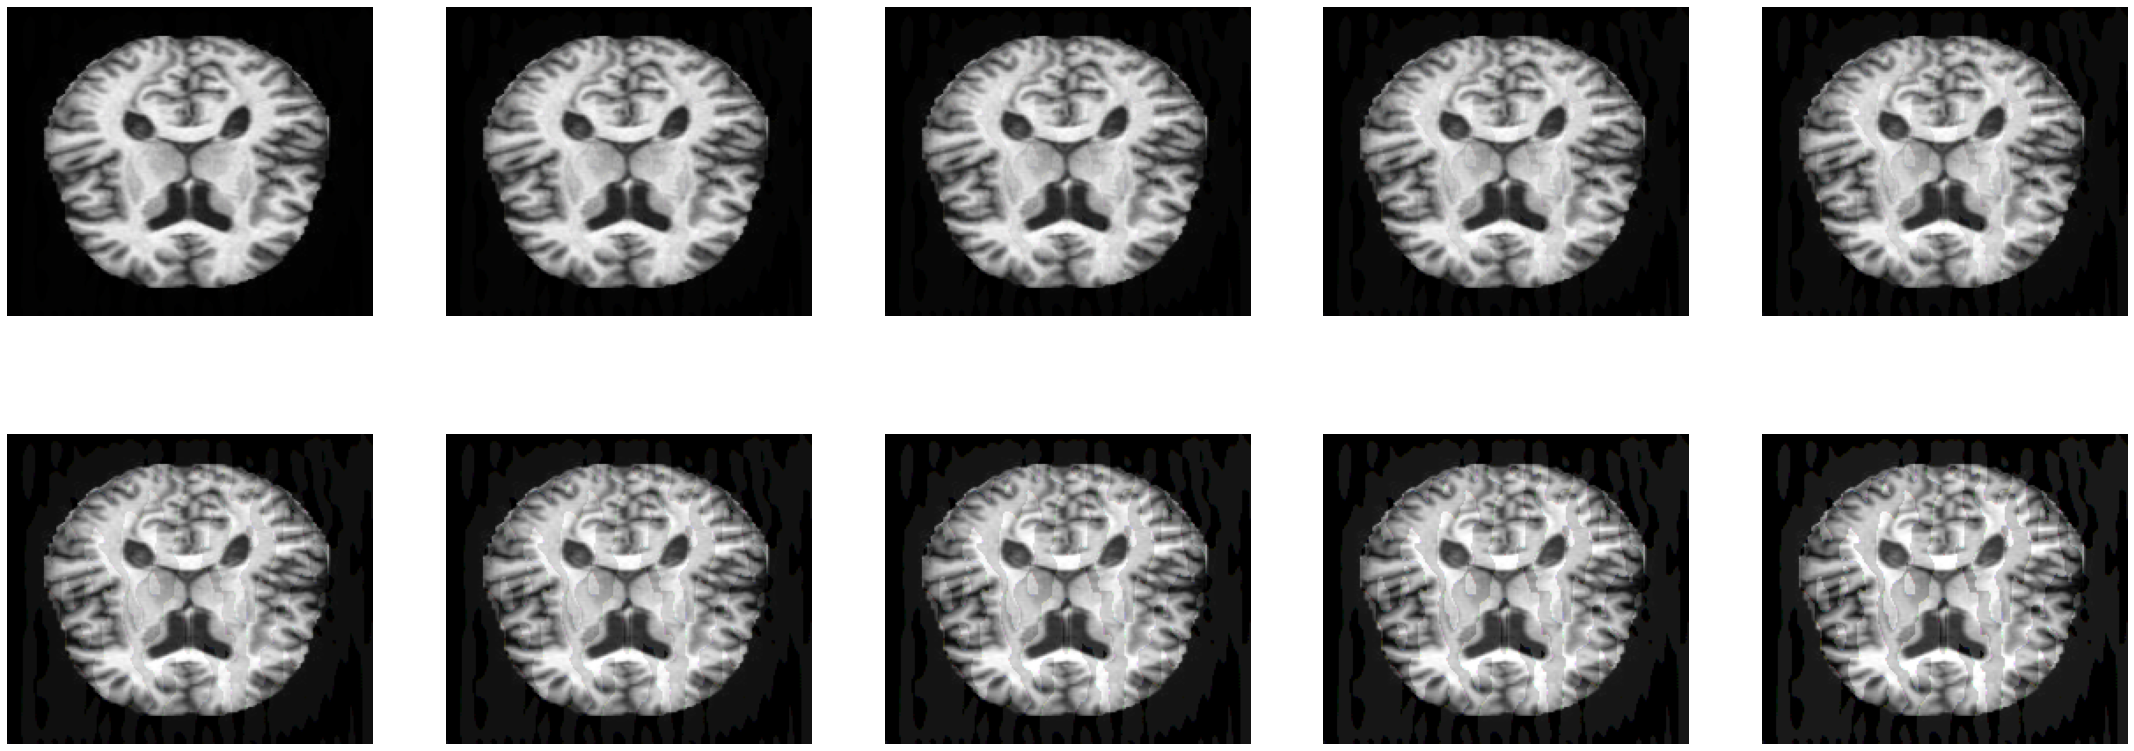

In [17]:
fig = plt.figure(figsize=(38, 38))
"""
position=1
fig=plt.subplot(2, 6, position)
fig.imshow(images[0])
fig.axis("off")
"""
position = 0
for img in liste_img_FGSM:
    position += 1
    fig=plt.subplot(5, 5, position)
    fig.imshow(img[0], cmap='gray')
    fig.axis('off')
    
print("Effet du FGSM sur nos images :")
plt.show()

### Résultats du modèle face au FGSM :

Text(0.5, 1.0, 'acc')

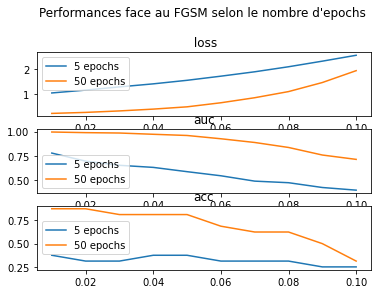

In [18]:

plt.subplot(3,1,1)
plt.plot(liste_eps, liste_loss)
plt.plot(liste_eps, liste_loss_50)
plt.legend(["5 epochs", "50 epochs"])
plt.title("Performances face au FGSM selon le nombre d'epochs \n \n loss")


plt.subplot(3,1,2)

plt.plot(liste_eps, liste_auc)
plt.plot(liste_eps, liste_auc_50)
plt.legend(["5 epochs", "50 epochs"])
plt.title("auc")


plt.subplot(3,1,3)

plt.plot(liste_eps, liste_acc)
plt.plot(liste_eps, liste_acc_50)
plt.legend(["5 epochs", "50 epochs"])
plt.title("acc")

#### L'entrainement n'améliore donc pas la robustesse face aux attaques

### Adversarial Patch :

Text(0.5, 1.0, 'Patch à ajouter sur nos images')

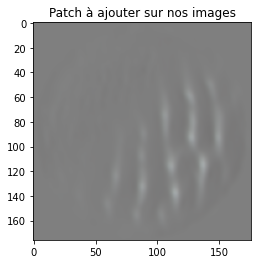

In [19]:
from art.attacks.evasion import  AdversarialPatch

image_shape = (224, 224, 3)
clip_values = (0, 255)
nb_classes = 4
batch_size = 16
scale_min = 0.4
scale_max = 1.0
rotation_max = 22.5
learning_rate = 5000.
max_iter = 500

liste_patch = []
ap = AdversarialPatch(classifier, targeted = False, max_iter = 10)

patch, patch_mask = ap.generate(x=images, y=labels)
plt.imshow(patch)
plt.title("Patch à ajouter sur nos images")

Text(0.5, 1.0, 'Image avec patch scale 0.7')

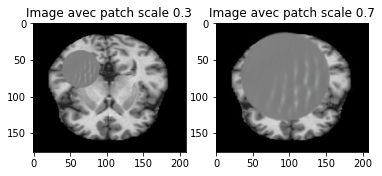

In [20]:
liste_img_ap =[]

liste_sc = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07,0.08,0.09,0.1,0.2,0.3,0.4,0.5,0.6,0.7]
for sc in liste_sc :
    liste_img_ap.append(ap.apply_patch(images, scale=sc))

plt.subplot(1,2,1)
plt.imshow(liste_img_ap[-5][-1])
plt.title('Image avec patch scale 0.3')


plt.subplot(1,2,2)
plt.imshow(liste_img_ap[-1][-1])
plt.title('Image avec patch scale 0.7')

### Résultats du modèle face au patch :

Text(0.5, 1.0, 'acc')

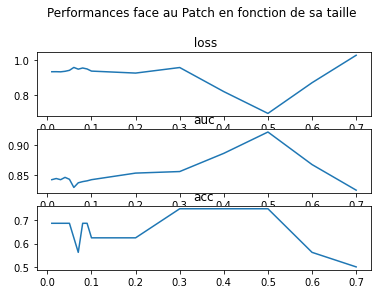

In [21]:
liste_eval_ap = []
for img in liste_img_ap:
    liste_eval_ap.append(model.evaluate(img,labels))


liste_loss_ap=[]
for _ in liste_eval_ap:
    liste_loss_ap.append(_[0])


liste_auc_ap=[]
for _ in liste_eval_ap:
    liste_auc_ap.append(_[1])


liste_acc_ap=[]
for _ in liste_eval_ap:
    liste_acc_ap.append(_[2])

#------------------ Plot ---------------

plt.subplot(3,1,1)
plt.plot(liste_sc, liste_loss_ap)
plt.title("Performances face au Patch en fonction de sa taille \n \n loss")


plt.subplot(3,1,2)
plt.plot(liste_sc, liste_auc_ap)
plt.title("auc")


plt.subplot(3,1,3)
plt.plot(liste_sc, liste_acc_ap)
plt.title("acc")

### Basic Iterative Method :

In [22]:
from art.attacks.evasion import BasicIterativeMethod
from art.attacks.evasion import ProjectedGradientDescent


liste_BIM = []
for i in liste_eps:
    liste_BIM.append(BasicIterativeMethod(estimator=classifier, eps=i, max_iter=10))
    
liste_img_BIM = []
for attack in liste_BIM:
    liste_img_BIM.append(attack.generate(images))

### Comparaison BIM et FGSM :

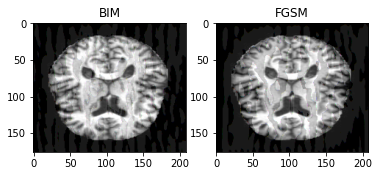

In [23]:
plt.subplot(1,2,1)
plt.title("BIM")
plt.imshow(liste_img_BIM[-1][0])
plt.subplot(1,2,2)
plt.title("FGSM")
plt.imshow(liste_img_FGSM[-1][0])

### Résultats du modèle face au BIM :

Text(0.5, 1.0, 'acc')

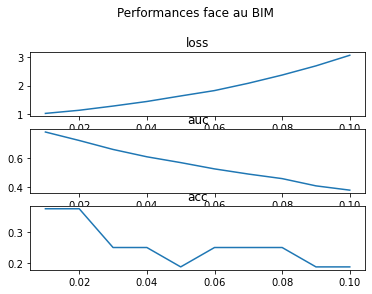

In [24]:
liste_eval_BIM = []
for img in liste_img_BIM:
    liste_eval_BIM.append(model.evaluate(img,labels))
    

liste_loss_BIM=[]
for _ in liste_eval_BIM:
    liste_loss_BIM.append(_[0])


liste_auc_BIM=[]
for _ in liste_eval_BIM:
    liste_auc_BIM.append(_[1])


liste_acc_BIM=[]
for _ in liste_eval_BIM:
    liste_acc_BIM.append(_[2])
    
    
#---------------------Plot------------------

plt.subplot(3,1,1)
plt.plot(liste_eps, liste_loss_BIM)
plt.title("Performances face au BIM \n \nloss")

plt.subplot(3,1,2)
plt.plot(liste_eps, liste_auc_BIM)
plt.title("auc")

plt.subplot(3,1,3)
plt.plot(liste_eps, liste_acc_BIM)
plt.title("acc")

### Comparaison BIM et FGSM :

Text(0.5, 1.0, 'acc')

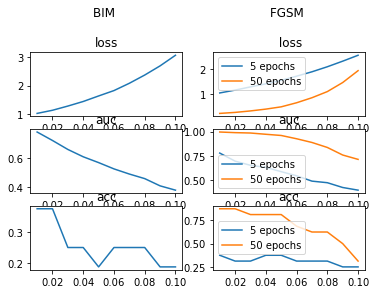

In [25]:
plt.subplot(3,2,1)
plt.plot(liste_eps, liste_loss_BIM)
plt.title("BIM \n \nloss")


plt.subplot(3,2,3)
plt.plot(liste_eps, liste_auc_BIM)
plt.title("auc")


plt.subplot(3,2,5)
plt.plot(liste_eps, liste_acc_BIM)
plt.title("acc")

#--------------------plot fgsm---------------


plt.subplot(3,2,2)
plt.plot(liste_eps, liste_loss)
plt.plot(liste_eps, liste_loss_50)
plt.legend(["5 epochs", "50 epochs"])
plt.title("FGSM \n \n loss")


plt.subplot(3,2,4)

plt.plot(liste_eps, liste_auc)
plt.plot(liste_eps, liste_auc_50)
plt.legend(["5 epochs", "50 epochs"])
plt.title("auc")


plt.subplot(3,2,6)

plt.plot(liste_eps, liste_acc)
plt.plot(liste_eps, liste_acc_50)
plt.legend(["5 epochs", "50 epochs"])
plt.title("acc")


### Try to split the data into X_train, y_train, X_test, y_test

In [26]:
from art.attacks.evasion import FastGradientMethod

from art.estimators.classification import KerasClassifier
import os
import numpy as np
import pandas as pd
import tensorflow as tf
#from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import PIL
import keras
#On cree un classifier art base sur notre model


import tensorflow as tf

In [27]:
new_model = keras.models.load_model("./final_alzheimer_model.h5")

In [28]:
ds1 = tf.keras.preprocessing.image_dataset_from_directory("Alzheimer_s Dataset/train",
    seed = 1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 5121 files belonging to 4 classes.


In [29]:
ds2 = tf.keras.preprocessing.image_dataset_from_directory("Alzheimer_s Dataset/test",
    seed = 1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 1279 files belonging to 4 classes.


In [30]:
ds = ds1.concatenate(ds2)

In [31]:
ds_labels = [labels for _, labels in tfds.as_numpy(ds.unbatch())]
ds_images = [images for images, _ in tfds.as_numpy(ds.unbatch())]

In [32]:
X= np.asarray(ds_images)
Y= np.asarray(ds_labels)

In [33]:
print(X.shape)

(6400, 176, 208, 3)


In [34]:
print(Y.shape)

(6400,)


In [35]:
import pandas as pd
from tensorflow.keras.utils import to_categorical

y = pd.Categorical(Y)
y_cat = to_categorical(y)
print(y_cat)
X = X/255

[[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 ...
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]


In [36]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y_cat, test_size = 0.2, shuffle=True)

In [37]:
h = new_model.fit(X_train, y_train, epochs=5, validation_data=(X_val,y_val), verbose=1)

Train on 5120 samples, validate on 1280 samples
Epoch 1/5
5120/5120 [==============================] - ETA: 0s - loss: 0.5854 - auc: 0.9429 - Acc: 0.7787

C:\Users\liber\OneDrive\Documents\ESME\INGE 1\Semestre 2\MINEURES\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


5120/5120 [==============================] - 491s 96ms/sample - loss: 0.5854 - auc: 0.9429 - Acc: 0.7787 - val_loss: 0.4051 - val_auc: 0.9719 - val_Acc: 0.8648
Epoch 2/5
5120/5120 [==============================] - 486s 95ms/sample - loss: 0.5777 - auc: 0.9439 - Acc: 0.7770 - val_loss: 0.4029 - val_auc: 0.9730 - val_Acc: 0.8648
Epoch 3/5
5120/5120 [==============================] - 491s 96ms/sample - loss: 0.5850 - auc: 0.9425 - Acc: 0.7807 - val_loss: 0.3959 - val_auc: 0.9738 - val_Acc: 0.8648
Epoch 4/5
5120/5120 [==============================] - 511s 100ms/sample - loss: 0.5845 - auc: 0.9422 - Acc: 0.7773 - val_loss: 0.3859 - val_auc: 0.9743 - val_Acc: 0.8703
Epoch 5/5
5120/5120 [==============================] - 432s 84ms/sample - loss: 0.5746 - auc: 0.9433 - Acc: 0.7809 - val_loss: 0.3819 - val_auc: 0.9750 - val_Acc: 0.8727


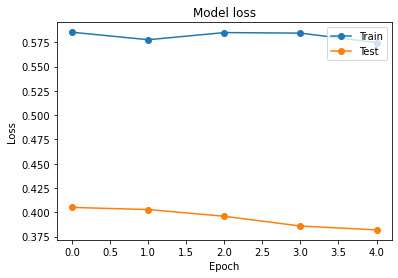

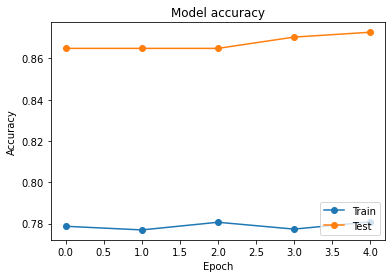

In [38]:
def courbe_perte(loss,val_loss): #courbe des pertes
  plt.figure()
  plt.plot(loss, '-o')
  plt.plot(val_loss, '-o')
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper right')  
  plt.show()

def courbe_accuracy(Acc,val_acc): #courbe des accuracy
  plt.figure()
  plt.plot(Acc, '-o')
  plt.plot(val_acc, '-o')
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='lower right')
  plt.show()

#on se sert de l'history pour afficher les courbes

courbe_perte(h.history['loss'], h.history['val_loss'])
courbe_accuracy(h.history['Acc'], h.history['val_Acc'])

In [37]:
#new_model.save("./trainedmodel.h5")
new_model = keras.models.load_model("./trainedmodel.h5")
classifier = KerasClassifier(model= new_model ,clip_values=(0,1),use_logits=False)
#new_classifier.fit(X_train, y_train, nb_epochs=5, verbose=1)

In [38]:
preds = np.argmax(classifier.predict(X_val), axis=1)
acc = np.sum(preds == np.argmax(y_val, axis=1)) / y_val.shape[0]
print("Test accuracy: %.2f%%" % (acc * 100))

C:\Users\liber\OneDrive\Documents\ESME\INGE 1\Semestre 2\MINEURES\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Test accuracy: 88.05%


In [44]:
#Repartition des classes dans les test
class1 =[]
class2=[]
class3=[]
class4=[]

for y in y_val:
    if (y == np.array([1,0,0,0])).all():
        class1.append(y)
    if (y == np.array([0,1,0,0])).all():
        class2.append(y)
    if (y == np.array([0,0,1,0])).all():
        class3.append(y)
    if (y == np.array([0,0,0,1])).all():
        class4.append(y)
print("Number of IRM MildDemented: " + str(len( class1)))
print("Number of IRM ModerateDemented: " + str(len(class2)))
print("Number of IRM NonDemented: " + str(len(class3)))
print("Number of IRM VeryMildDemented: " + str(len(class4)))

Number of IRM MildDemented: 185
Number of IRM ModerateDemented: 12
Number of IRM NonDemented: 610
Number of IRM VeryMildDemented: 473


In [45]:
acc_class1=0
acc_class2=0
acc_class3=0
acc_class4=0
for i in range (0,len(y_val)):
    if preds[i] == np.argmax(y_val, axis=1)[i]:
        if y_val[i][0] == 1 :
            acc_class1 +=1
        elif y_val[i][1] == 1:
            acc_class2 +=1
        elif y_val[i][2] == 1:
            acc_class3 +=1
        elif y_val[i][3] == 1:
            acc_class4 +=1
print("Test accuracy  - MildDemented %.2f%%" % (acc_class1/len(class1)*100))   
print("Test accuracy - ModeratedDemented %.2f%%" % (acc_class2/len(class2)*100))
print("Test accuracy - NonDemented %.2f%%" % (acc_class3/len(class3)*100))
print("Test accuracy - VeryMildDemented %.2f%%" % (acc_class4/len(class4)*100))

Test accuracy  - MildDemented 77.30%
Test accuracy - ModeratedDemented 75.00%
Test accuracy - NonDemented 91.48%
Test accuracy - VeryMildDemented 86.26%


## FGSM

In [49]:
eps_f = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]
liste_acc_fgsm =[]
for epsilon in eps_f :
    adv_crafter = FastGradientMethod(classifier, eps=epsilon)
    X_test_fgsm = adv_crafter.generate(x=X_val)
    preds_fgsm = np.argmax(classifier.predict(X_test_fgsm), axis=1)
    acc_fgsm = np.sum(preds_fgsm == np.argmax(y_val, axis=1)) / y_val.shape[0]
    liste_acc_fgsm.append(acc_fgsm)

Text(0.5, 1.0, 'Acc selon epsilon (fgsm attack)')

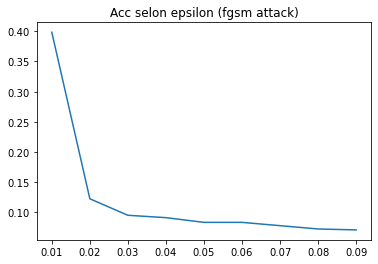

In [50]:
import matplotlib.pyplot as plt
plt.plot(eps_f, liste_acc_fgsm)
plt.title("Acc selon epsilon (fgsm attack)")

In [51]:
acc_fgsm_class1=0
acc_fgsm_class2=0
acc_fgsm_class3=0
acc_fgsm_class4=0
for i in range (0,len(y_val)):
    if preds_fgsm[i] == np.argmax(y_val, axis=1)[i]:
        if y_val[i][0] == 1 :
            acc_fgsm_class1 +=1
        elif y_val[i][1] == 1:
            acc_fgsm_class2 +=1
        elif y_val[i][2] == 1:
            acc_fgsm_class3 +=1
        elif y_val[i][3] == 1:
            acc_fgsm_class4 +=1
print("Test accuracy on fgsm attack - MildDemented %.2f%%" % (acc_fgsm_class1/len(class1)*100))   
print("Test accuracy on fgsm attack - ModeratedDemented %.2f%%" % (acc_fgsm_class2/len(class2)*100))
print("Test accuracy on fgsm attack - NonDemented %.2f%%" % (acc_fgsm_class3/len(class3)*100))
print("Test accuracy on fgsm attack - VeryMildDemented %.2f%%" % (acc_fgsm_class4/len(class4)*100))

Test accuracy on fgsm attack - MildDemented 16.22%
Test accuracy on fgsm attack - ModeratedDemented 8.33%
Test accuracy on fgsm attack - NonDemented 6.07%
Test accuracy on fgsm attack - VeryMildDemented 4.86%


 ## IBM

In [52]:
eps_b = [0.01, 0.04, 0.08, 0.12, 0.16, 0.2, 0.24, 0.28, 0.32]
from art.attacks.evasion import BasicIterativeMethod
liste_acc_bim=[]
for epsilon in eps_b:
    bim_crafter = BasicIterativeMethod(estimator=classifier, eps=epsilon, max_iter=3)
    X_test_bim = bim_crafter.generate(x=X_val)
    # Evaluate the classifier on the adversarial examples
    bim_preds = np.argmax(classifier.predict(X_test_bim), axis=1)
    acc_bim = np.sum(bim_preds == np.argmax(y_val, axis=1)) / y_val.shape[0]
    liste_acc_bim.append(acc_bim)

Text(0.5, 1.0, 'Acc selon epsilon (bim attack)')

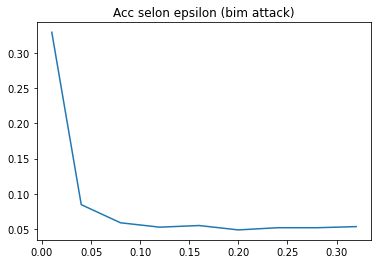

In [53]:
plt.plot(eps_b, liste_acc_bim)
plt.title("Acc selon epsilon (bim attack)")

In [54]:
acc_bim_class1=0
acc_bim_class2=0
acc_bim_class3=0
acc_bim_class4=0
for i in range (0,len(y_val)):
    if bim_preds[i] == np.argmax(y_val, axis=1)[i]:
        if y_val[i][0] == 1 :
            acc_bim_class1 +=1
        elif y_val[i][1] == 1:
            acc_bim_class2 +=1
        elif y_val[i][2] == 1:
            acc_bim_class3 +=1
        elif y_val[i][3] == 1:
            acc_bim_class4 +=1
print("Test accuracy on bim attack - MildDemented %.2f%%" % (acc_bim_class1/len(class1)*100))   
print("Test accuracy on bim attack - ModeratedDemented %.2f%%" % (acc_bim_class2/len(class2)*100))
print("Test accuracy on bim attack - NonDemented %.2f%%" % (acc_bim_class3/len(class3)*100))
print("Test accuracy on bim attack - VeryMildDemented %.2f%%" % (acc_bim_class4/len(class4)*100))

Test accuracy on bim attack - MildDemented 23.24%
Test accuracy on bim attack - ModeratedDemented 0.00%
Test accuracy on bim attack - NonDemented 3.93%
Test accuracy on bim attack - VeryMildDemented 0.21%


## PATCH

In [ ]:
# from art.attacks.evasion import  AdversarialPatch
liste_acc_patch=[]
patch_crafter = AdversarialPatch(classifier, targeted = False, max_iter = 3)
patch, patch_mask = patch_crafter.generate(x=X_val, y=y_val)
plt.imshow(patch)
eps = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for size in eps : 
    X_test_patch = patch_crafter.apply_patch(X_val, size)
    patch_preds = np.argmax(classifier.predict(X_test_patch), axis=1)
    acc_patch = np.sum(patch_preds == np.argmax(y_val, axis=1)) / y_val.shape[0]
    liste_acc_patch.append(acc_patch)

Text(0.5, 1.0, 'Acc selon size patch (patch attack)')

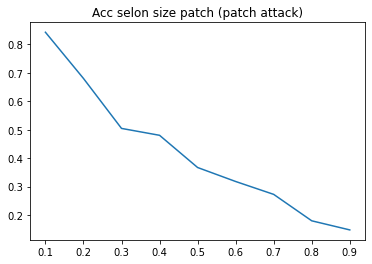

In [57]:
plt.plot(eps, liste_acc_patch)
plt.title("Acc selon size patch (patch attack)")

In [58]:
print(liste_acc_patch)

[0.84296875, 0.68046875, 0.5046875, 0.48046875, 0.3671875, 0.31796875, 0.27265625, 0.1796875, 0.14765625]


In [61]:
acc_patch_class1=0
acc_patch_class2=0
acc_patch_class3=0
acc_patch_class4=0
for i in range (0,len(y_val)):
    if patch_preds[i] == np.argmax(y_val, axis=1)[i]:
        if y_val[i][0] == 1 :
            acc_patch_class1 +=1
        elif y_val[i][1] == 1:
            acc_patch_class2 +=1
        elif y_val[i][2] == 1:
            acc_patch_class3 +=1
        elif y_val[i][3] == 1:
            acc_patch_class4 +=1
print("Test accuracy on patch attack - MildDemented %.2f%%" % (acc_patch_class1/len(class1)*100))   
print("Test accuracy on patch attack - ModeratedDemented %.2f%%" % (acc_patch_class2/len(class2)*100))
print("Test accuracy on patch attack - NonDemented %.2f%%" % (acc_patch_class3/len(class3)*100))
print("Test accuracy on patch attack - VeryMildDemented %.2f%%" % (acc_patch_class4/len(class4)*100))

Test accuracy on patch attack - MildDemented 72.43%
Test accuracy on patch attack - ModeratedDemented 66.67%
Test accuracy on patch attack - NonDemented 90.00%
Test accuracy on patch attack - VeryMildDemented 84.14%


### Sauvegarde des ACC

In [62]:
print(liste_acc_fgsm)

[0.3984375, 0.12265625, 0.0953125, 0.09140625, 0.08359375, 0.08359375, 0.078125, 0.07265625, 0.07109375]


In [63]:
print(liste_acc_bim)

[0.3296875, 0.084375, 0.05859375, 0.05234375, 0.0546875, 0.0484375, 0.0515625, 0.0515625, 0.053125]


In [64]:
print(liste_acc_patch)

[0.8734375, 0.87265625, 0.871875, 0.871875, 0.86796875, 0.87265625, 0.86640625, 0.86015625, 0.85078125]


In [39]:
liste_acc_fgsm = [0.3984375, 0.12265625, 0.0953125, 0.09140625, 0.08359375, 0.08359375, 0.078125, 0.07265625, 0.07109375]

In [40]:
liste_acc_bim = [0.3296875, 0.084375, 0.05859375, 0.05234375, 0.0546875, 0.0484375, 0.0515625, 0.0515625, 0.053125]

In [41]:
liste_acc_patch = [0.84296875, 0.68046875, 0.5046875, 0.48046875, 0.3671875, 0.31796875, 0.27265625, 0.1796875, 0.14765625]

In [44]:
print(liste_acc_fgsm)

[0.3984375, 0.12265625, 0.0953125, 0.09140625, 0.08359375, 0.08359375, 0.078125, 0.07265625, 0.07109375]


## Defense

#### Gaussian Augmentation

In [38]:
from art.defences.preprocessor import GaussianAugmentation
ga = GaussianAugmentation(ratio=0.01, clip_values=(0, 1))

In [39]:
gaussian_model = KerasClassifier(model= new_model ,preprocessing_defences = [ga])
gaussian_model.fit(X_train, y_train, nb_epochs=5)

Train on 5171 samples
Epoch 1/5
5171/5171 [==============================] - 680s 131ms/sample - loss: 0.5548 - auc: 0.9465 - Acc: 0.7817
Epoch 2/5
5171/5171 [==============================] - 710s 137ms/sample - loss: 0.5468 - auc: 0.9481 - Acc: 0.7908
Epoch 3/5
5171/5171 [==============================] - 634s 123ms/sample - loss: 0.5535 - auc: 0.9469 - Acc: 0.7873
Epoch 4/5
5171/5171 [==============================] - 633s 122ms/sample - loss: 0.5567 - auc: 0.9466 - Acc: 0.7935
Epoch 5/5
5171/5171 [==============================] - 610s 118ms/sample - loss: 0.5296 - auc: 0.9506 - Acc: 0.7896


In [56]:
#FGSM 
eps_f = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]
liste_acc_fgsm_ga=[]
for epsilon in eps_f :
    adv_crafter = FastGradientMethod(classifier, eps=epsilon)
    X_test_fgsm= adv_crafter.generate(x=X_val)
    preds_fgsm_ga = np.argmax(gaussian_model.predict(X_test_fgsm), axis=1)
    acc_fgsm_ga = np.sum(preds_fgsm_ga == np.argmax(y_val, axis=1)) / y_val.shape[0]
    liste_acc_fgsm_ga.append(acc_fgsm_ga)

Text(0.5, 1.0, 'Acc selon epsilon (fgsm attack)')

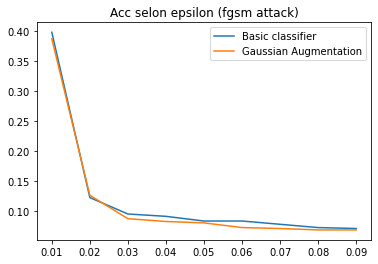

In [57]:
import matplotlib.pyplot as plt

plt.plot(eps_f, liste_acc_fgsm)
plt.plot(eps_f, liste_acc_fgsm_ga)
plt.legend(["Basic classifier", "Gaussian Augmentation"])
plt.title("Acc selon epsilon (fgsm attack)")

In [59]:
#BIM
eps_b = [0.01, 0.04, 0.08, 0.12, 0.16, 0.2, 0.24, 0.28, 0.32]
liste_acc_bim_ga=[]
for epsilon in eps_b :
    bim_crafter = BasicIterativeMethod(estimator=classifier, eps=epsilon, max_iter=3)
    X_test_bim= bim_crafter.generate(x=X_val)
    preds_bim_ga = np.argmax(gaussian_model.predict(X_test_bim), axis=1)
    acc_bim_ga = np.sum(preds_bim_ga == np.argmax(y_val, axis=1)) / y_val.shape[0]
    liste_acc_bim_ga.append(acc_bim_ga)

Text(0.5, 1.0, 'Acc selon epsilon (bim attack)')

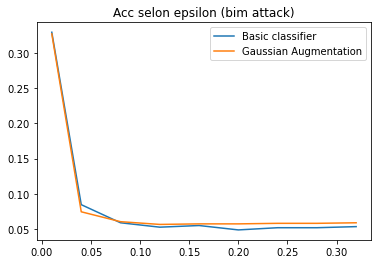

In [67]:
liste_acc_bim = [0.3296875, 0.084375, 0.05859375, 0.05234375, 0.0546875, 0.0484375, 0.0515625, 0.0515625, 0.053125]
plt.plot(eps_b, liste_acc_bim)
plt.plot(eps_b, liste_acc_bim_ga)
plt.legend(["Basic classifier", "Gaussian Augmentation"])
plt.title("Acc selon epsilon (bim attack)")

In [46]:
#PATCH
eps = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
patch_crafter = AdversarialPatch(classifier, targeted = False, max_iter = 3)
patch, patch_mask = patch_crafter.generate(x=X_val, y=y_val)
liste_acc_patch_ga=[]
for size in eps:
    X_test_patch = patch_crafter.apply_patch(X_val, size)
    patch_preds_ga = np.argmax(gaussian_model.predict(X_test_patch), axis=1)
    acc_patch_ga = np.sum(patch_preds_ga == np.argmax(y_val, axis=1)) / y_val.shape[0]
    liste_acc_patch_ga.append(acc_patch_ga)

Text(0.5, 1.0, 'Acc selon patch_size (patch attack)')

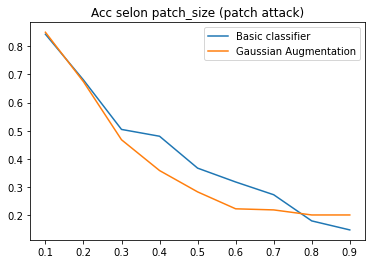

In [52]:
plt.plot(eps, liste_acc_patch)
plt.plot(eps, liste_acc_patch_ga)
plt.legend(["Basic classifier", "Gaussian Augmentation"])
plt.title("Acc selon patch_size (patch attack)")

In [58]:
print(liste_acc_fgsm_ga)

[0.3875, 0.1265625, 0.0875, 0.0828125, 0.08046875, 0.07265625, 0.07109375, 0.06875, 0.06875]


In [54]:
print(liste_acc_bim_ga)

[0.3296875, 0.074375, 0.05859375, 0.05934375, 0.0590875, 0.0594375, 0.05915625, 0.05915625, 0.059125]


In [55]:
print(liste_acc_patch_ga)

[0.85, 0.67421875, 0.46796875, 0.35859375, 0.2828125, 0.22265625, 0.21875, 0.20078125, 0.20078125]


##### Sauvegarde des accuracy

In [52]:
liste_acc_fgsm_ga=[0.3875, 0.1265625, 0.0875, 0.0828125, 0.08046875, 0.07265625, 0.07109375, 0.06875, 0.06875]
liste_acc_bim_ga=[0.3296875, 0.074375, 0.05859375, 0.05934375, 0.0590875, 0.0594375, 0.05915625, 0.05915625, 0.059125]
liste_acc_patch_ga=[0.85, 0.67421875, 0.46796875, 0.42859375, 0.2828125, 0.22265625, 0.21875, 0.20078125, 0.20078125]

eps_b = [0.01, 0.04, 0.08, 0.12, 0.16, 0.2, 0.24, 0.28, 0.32]
eps_f = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]

#### AdversarialTrainer

In [56]:
from art.defences.trainer import AdversarialTrainer

adv_crafter = FastGradientMethod(classifier, eps=0.1)
X_test_fgsm= adv_crafter.generate(x=X_val)
bim_crafter = BasicIterativeMethod(estimator=classifier, eps=0.3, max_iter=3)
X_test_bim = bim_crafter.generate(x=X_val)
robust_classifier = AdversarialTrainer(classifier,[adv_crafter, bim_crafter],ratio=0.2)
robust_classifier.fit(X_train, y_train)

In [57]:
liste_acc_fgsm_advtrainer=[]
liste_acc_bim_advtrainer=[]
liste_acc_patch_advtrainer=[]

for epsilon in eps_f :
    #FGSM
    adv_crafter = FastGradientMethod(classifier, eps=epsilon)
    X_test_fgsm= adv_crafter.generate(x=X_val)
    robust_preds_fgsm = np.argmax(robust_classifier.predict(X_test_fgsm), axis=1)
    acc_fgsm_robust = np.sum(robust_preds_fgsm == np.argmax(y_val, axis=1)) / y_val.shape[0]
    liste_acc_fgsm_advtrainer.append(acc_fgsm_robust)

In [58]:
print(liste_acc_fgsm_advtrainer)

[0.484375, 0.2375, 0.1484375, 0.13359375, 0.12890625, 0.12734375, 0.12578125, 0.1234375, 0.1203125]


Text(0.5, 1.0, 'Acc selon epsilon (fgsm attack)')

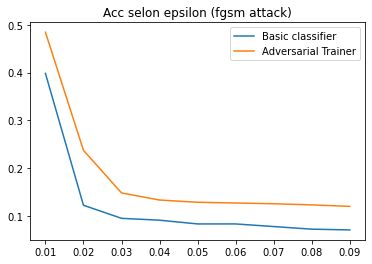

In [61]:
plt.plot(eps_f, liste_acc_fgsm)
plt.plot(eps_f, liste_acc_fgsm_advtrainer)
plt.legend(["Basic classifier", "Adversarial Trainer"])
plt.title("Acc selon epsilon (fgsm attack)")

Text(0.5, 1.0, 'Acc selon epsilon (fgsm attack)')

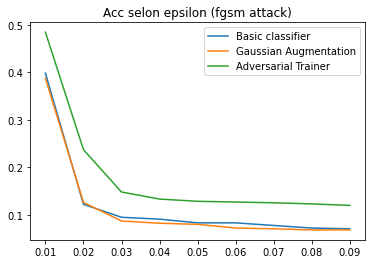

In [59]:
plt.plot(eps_f, liste_acc_fgsm)
plt.plot(eps_f, liste_acc_fgsm_ga)
plt.plot(eps_f, liste_acc_fgsm_advtrainer)
plt.legend(["Basic classifier", "Gaussian Augmentation", "Adversarial Trainer"])
plt.title("Acc selon epsilon (fgsm attack)")

In [62]:
for epsilon in eps_b :
    #BIM
    bim_crafter = BasicIterativeMethod(estimator=classifier, eps=epsilon, max_iter=3)
    X_test_bim= bim_crafter.generate(x=X_val)
    robust_preds_bim = np.argmax(robust_classifier.predict(X_test_bim), axis=1)
    acc_bim_robust = np.sum(robust_preds_bim == np.argmax(y_val, axis=1)) / y_val.shape[0]
    liste_acc_bim_advtrainer.append(acc_bim_robust)

In [63]:
print(liste_acc_bim_advtrainer)

[0.44375, 0.128125, 0.11171875, 0.1125, 0.109375, 0.10625, 0.103125, 0.096875, 0.09375]


Text(0.5, 1.0, 'Acc selon epsilon (bim attack)')

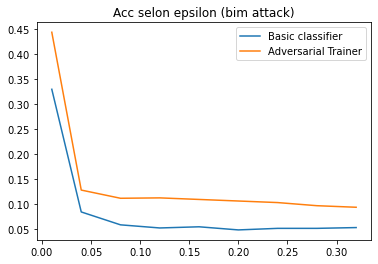

In [65]:
plt.plot(eps_b, liste_acc_bim)
plt.plot(eps_b, liste_acc_bim_advtrainer)
plt.legend(["Basic classifier", "Adversarial Trainer"])
plt.title("Acc selon epsilon (bim attack)")

Text(0.5, 1.0, 'Acc selon epsilon (bim attack)')

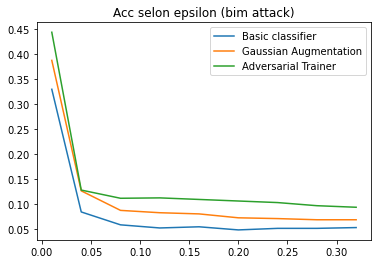

In [64]:
plt.plot(eps_b, liste_acc_bim)
plt.plot(eps_b, liste_acc_fgsm_ga)
plt.plot(eps_b, liste_acc_bim_advtrainer)
plt.legend(["Basic classifier", "Gaussian Augmentation", "Adversarial Trainer"])
plt.title("Acc selon epsilon (bim attack)")

##### Save the data

In [66]:
liste_acc_fgsm_advtrainer = [0.484375, 0.2375, 0.1484375, 0.13359375, 0.12890625, 0.12734375, 0.12578125, 0.1234375, 0.1203125]
liste_acc_bim_advtrainer =[0.44375, 0.128125, 0.11171875, 0.1125, 0.109375, 0.10625, 0.103125, 0.096875, 0.09375]